# Modules

In [184]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
from sklearn.covariance import GraphicalLassoCV

data_path ="/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Option Biologie/genetique_network/data_challenge/public_dat"

#charger les données dans un dico 
data ={}
for file in os.listdir(data_path):
    data[f"{file[:-4]}"] = pd.read_csv(os.path.join(data_path,file))
    data[f"{file[:-4]}"] = data[f"{file[:-4]}"].fillna(data[f"{file[:-4]}"].mean(axis=0))


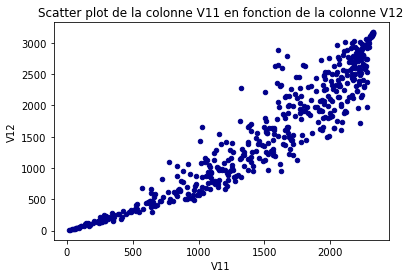

In [185]:
def random_vis(data):
    cols = np.random.choice(data.columns,2)
    ax1 = data.plot.scatter(x=cols[0],y=cols[1],c='DarkBlue')
    ax1.set_title(f"Scatter plot de la colonne {cols[0]} en fonction de la colonne {cols[1]}")

random_vis(data["data5"])


# Lasso méthode 

In [189]:
def lasso(data,name,printMB=True):
    """Fonction pour appliquer la méthode Lasso pour retrouver la couverture de Markov 
    de façon à obtenir un tableau de prédiction, sous la forme d’une liste de liens
    'cause','effte','score'.Calcule les scores de précision/recall obtenus le dataset et le fichier target
    """
    print(f"Nous travaillons avec le réseau {name}")
    # Standardisation des données pour améliorer les performances de Lasso
    scaler = StandardScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data),index=data.index,columns=data.columns)
    
    Cause, Effet, Score = [],[],[] #garder en mémoire les valeurs 

    for col in data_scaled.columns:

        # Séparation de la variable "col" des autres variables
        X = data_scaled.drop(col, axis=1)
        y = data_scaled[col]

        # Application de la régression Lasso avec sélection automatique du meilleur alpha via de la cross validation
        # la paramètre alpha nous donne le diamètre de la boulle de recherche 
        lasso = LassoCV(cv=5, random_state=0, max_iter=10000).fit(X, y)

        # Identification des variables (non nulles) sélectionnées par la méthode Lasso 
        coefficients = lasso.coef_

        selected_features = X.columns[np.abs(coefficients) >1e-3] #selection des variables significative
        selected_coeff = np.abs(coefficients)[np.abs(coefficients) >1e-3]

        for c,s in zip(selected_features,selected_coeff):
            Cause.append(c)
            Effet.append(col)
            Score.append(s)
        # Affichage de la couverture de Markov de V0
        if printMB:
            print(f"La couverture de Markov estimée de {col} comprend les variables suivantes : {selected_features.tolist()}")
            print(f"Les scores de {col} pour les variables précédentes sont les suivant : {np.round(selected_coeff,2).tolist()}")

    predictions_network = pd.DataFrame(np.array([Cause, Effet, Score]).T,columns=["Cause", "Effect", "Score"])

    predictions_network = predictions_network.sort_values(by="Score", ascending=False)

    predictions_network.to_csv(f"/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Option Biologie/genetique_network/data_challenge/predictions/pred_lasso/lasso_{name}.csv",index=False)

    
for k in data.keys():
    lasso(data[k],k,printMB=False)

Nous travaillons avec le réseau data5
Nous travaillons avec le réseau data4


/home/ibotcazou/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e-02, tolerance: 8.116e-03
  model = cd_fast.enet_coordinate_descent(


Nous travaillons avec le réseau data2
Nous travaillons avec le réseau data1
Nous travaillons avec le réseau data3


# Méthode GENIE3

In [192]:
from GENIE3 import *

def Genie3_true(data,name,tree_method='ET',K = 7,ntrees = 100):
    """Fonction pour appliquer la méthode GENIE3 
    de façon à obtenir une matrice de prédiction pour la causalité.
    Calcule les scores de précision/recall obtenus le dataset et le fichier target
    """
    print(f"Nous travaillons avec le réseau {name}")
    # Standardisation des données pour améliorer les performances de Lasso
    scaler = StandardScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data),index=data.index,columns=data.columns)
    
    # Use Extra-Trees method :tree_method='ET'
    # Number of randomly chosen candidate regulators at each node of a tree : K = 7
    # Number of trees per ensemble : ntrees = 100
    
    # Run the method with these settings
    VIM3 = GENIE3(np.array(data_scaled))#,tree_method=tree_method,K=K,ntrees=ntrees) 

    #Créer la prédiction matrice de causalité
    causal_matrix_pred = pd.DataFrame(VIM3,index=data.columns,columns=data.columns)

    get_link_list(VIM3)

    #Tableau des scores 
    Cause, Effet, Score = [],[],[] #garder en mémoire les valeurs 

    for idx in causal_matrix_pred.index:
        for col in causal_matrix_pred.columns:
            if col != idx:
                Cause.append(idx)
                Effet.append(col)
                Score.append(causal_matrix_pred.loc[idx,col])

    predictions_network = pd.DataFrame(np.array([Cause, Effet, Score]).T,columns=["Cause", "Effect", "Score"])

    predictions_network = predictions_network.sort_values(by="Score", ascending=False)

    predictions_network.to_csv(f"/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Option Biologie/genetique_network/data_challenge/predictions/genie3_RF_sqrt_1000/predictions_network{name[-1]}.csv",index=False)

for k in data.keys():
    Genie3_true(data[k],k)

Nous travaillons avec le réseau data5
Tree method: RF
K: sqrt
Number of trees: 1000


running single threaded jobs
Gene 1/20...
Gene 2/20...
Gene 3/20...
Gene 4/20...
Gene 5/20...
Gene 6/20...
Gene 7/20...
Gene 8/20...
Gene 9/20...
Gene 10/20...
Gene 11/20...
Gene 12/20...
Gene 13/20...
Gene 14/20...
Gene 15/20...
Gene 16/20...
Gene 17/20...
Gene 18/20...
Gene 19/20...
Gene 20/20...
Elapsed time: 43.11 seconds
G15	G13	0.300164
G13	G9	0.295298
G9	G18	0.272906
G13	G15	0.271357
G9	G13	0.251480
G15	G9	0.235769
G10	G20	0.222971
G5	G11	0.218796
G13	G18	0.218146
G11	G5	0.217936
G14	G10	0.209992
G19	G6	0.203653
G11	G4	0.197943
G19	G16	0.196252
G18	G9	0.194901
G10	G14	0.191063
G5	G4	0.189931
G19	G1	0.184535
G1	G19	0.180973
G19	G17	0.179389
G20	G14	0.178087
G1	G6	0.177316
G9	G15	0.174612
G17	G1	0.174418
G15	G8	0.172633
G14	G20	0.170835
G19	G11	0.169756
G17	G19	0.165539
G19	G2	0.162052
G17	G6	0.160588
G15	G18	0.156269
G18	G13	0.155689
G6	G1	0.154435
G6	G19	0.152636
G20	G10	0.151182
G6	G12	0.15074